In [111]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb

In [112]:
!pip install pyunpack
!pip install patool

In [113]:
from pyunpack import Archive
import shutil
import os

for dirname, _, filenames in os.walk('/kaggle/input/kkbox-music-recommendation-challenge/'):
    for filename in filenames:
        Archive('/kaggle/input/kkbox-music-recommendation-challenge/' + filename).extractall('/kaggle/working/')

In [114]:
data_path = '/kaggle/working/'
train = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'str',
                                                'source_system_tab' : 'str',
                                                  'source_screen_name' : 'str',
                                                  'source_type' : 'str',
                                                  'target' : np.uint8,
                                                  'song_id' : 'str'})
test = pd.read_csv(data_path + 'test.csv', dtype={'msno' : 'str',
                                                'source_system_tab' : 'str',
                                                'source_screen_name' : 'str',
                                                'source_type' : 'str',
                                                'song_id' : 'str'})
songs = pd.read_csv(data_path + 'songs.csv',dtype={'genre_ids': 'str',
                                                  'language' : 'str',
                                                  'artist_name' : 'str',
                                                  'composer' : 'str',
                                                  'lyricist' : 'str',
                                                  'song_id' : 'str'})
members = pd.read_csv(data_path + 'members.csv',
                      dtype={'city' : 'str',
                             'bd' : np.uint8,
                             'gender' : 'str',
                             'registered_via' : 'int'}
                     ,parse_dates=["registration_init_time","expiration_date"])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')

In [115]:
train

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1


In [116]:
songs

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),NaN,-1.0
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),NaN,NaN,3.0
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,NaN,NaN,52.0
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,NaN,NaN,52.0


In [117]:
members

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13
...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,0,NaN,7,2013-11-11,2017-09-10
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,18,male,3,2014-10-24,2017-05-18
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,0,NaN,7,2013-08-02,2017-09-08
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,0,NaN,7,2015-10-20,2017-09-20


In [118]:
songs_extra

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001
...,...,...,...
2295966,hLnetpF6UbPg28sSfXnPE2vsdaGsLvddlXEdJR4VTIA=,Deep Breathing,PLL431720793
2295967,N+6vJ8actKQm0S3Fpf4elipTjoAo9ev28aA5FJN5e40=,In Hiding,US5UL1519827
2295968,pv35uG0ts05mWtirM/AMOWEzbHxIVart5ZzRXqKUY1c=,Il Est Ne Le Divin Enfant,PLL431502294
2295969,QSySnm8jt2Go7byY34/PxsZP6dPCins2j2cyYquNhBo=,The Exodus Song,DEPZ69316095


Сразу заметим, есть нулевые значения в данных. Имеем полную информацию о пользователях и о треках 

Соберем данные вместе, чтобы дальше провести какой-нибудь анализ 

In [119]:
train_members = pd.merge(train, members, on='msno', how='left')
train_merged = pd.merge(train_members, songs, on='song_id', how='left')
train_merged

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,4,26,female,9,2004-12-18,2017-09-30,267958.0,1259,Dr. Dre,Andre R. Young| Melvin Charles Bradford| Shawn...,NaN,52.0
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,1,0,NaN,7,2013-06-27,2017-10-06,227404.0,465,R. City feat. Adam Levine,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,52.0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,1,0,NaN,7,2013-06-27,2017-10-06,258298.0,465,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,3.0
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,5,0,NaN,9,2015-02-13,2017-09-18,524146.0,2122,Brad Mehldau Trio,NaN,NaN,52.0


In [120]:
test_members = pd.merge(test, members, on='msno', how='left')
test_merged = pd.merge(test_members, songs, on='song_id', how='left')
test_merged

,id,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,NaN,7,2016-02-19,2017-09-18,224130.0,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,1,0,NaN,7,2016-02-19,2017-09-18,320470.0,465,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,3.0
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,1,0,NaN,4,2016-11-17,2016-11-24,315899.0,2022,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,17.0
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,3,30,male,9,2007-07-25,2017-04-30,285210.0,465,U2,The Edge| Adam Clayton| Larry Mullen| Jr.,NaN,52.0
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,3,30,male,9,2007-07-25,2017-04-30,197590.0,873,Yoga Mr Sound,Neuromancer,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,2556785,XmA/cIkXJ8jZUfsUc4bBfJVWMMqmylnPW0WVkg/iz0s=,wJoWzZd7AL+qX9xZWZwRTzGRYg0Lxcl5Pe+9n5hZgAQ=,discover,Online playlist more,online-playlist,13,41,female,9,2010-11-26,2017-09-21,247640.0,1609,The Chainsmokers & Coldplay,Andrew Taggart| Christopher Martin| Will Champ...,Andrew Taggart| Christopher Martin| Will Champ...,52.0
2556786,2556786,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,KCJ8BlSfRQRgB7EVuzFvg52AhR8m2fT032MzN5ewbEI=,discover,NaN,online-playlist,13,24,male,9,2014-05-06,2017-09-12,197067.0,458,郭美美 (Jocie Guo),小路,小路,3.0
2556787,2556787,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,ySDsKJSnhFMESzC9mBhY0hnFEEBWDYx0FOMNcYDLb/A=,discover,NaN,online-playlist,13,24,male,9,2014-05-06,2017-09-12,212950.0,458,問樂團 (Guess What),Skot Suyama陶山/Linkin Park,陳天佑/謝和弦/Linkin Park,3.0
2556788,2556788,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,WXH8kL8e+0H2jY+s2Y6FpHyyHdaMYV3b6yfDa3FAt9U=,discover,NaN,online-playlist,13,24,male,9,2014-05-06,2017-09-12,164414.0,465,陳冠宇 (Kaiel Chen),NaN,NaN,3.0


In [121]:
del train_members
del test_members

In [122]:
import seaborn as sns


<Axes: xlabel='target', ylabel='count'>

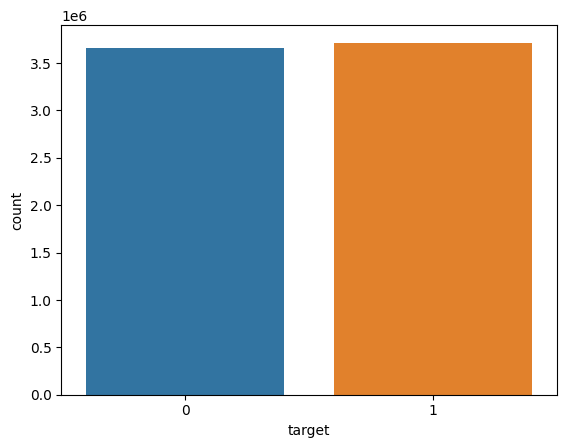

In [123]:
sns.countplot(x='target', data=train_merged)

Нет дисбаланса классов, это хорошо

In [124]:
train_merged

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,4,26,female,9,2004-12-18,2017-09-30,267958.0,1259,Dr. Dre,Andre R. Young| Melvin Charles Bradford| Shawn...,NaN,52.0
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,1,0,NaN,7,2013-06-27,2017-10-06,227404.0,465,R. City feat. Adam Levine,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,52.0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,1,0,NaN,7,2013-06-27,2017-10-06,258298.0,465,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,3.0
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,5,0,NaN,9,2015-02-13,2017-09-18,524146.0,2122,Brad Mehldau Trio,NaN,NaN,52.0


In [125]:
def check_missing_values(df):
    print (df.isnull().values.any())
    if (df.isnull().values.any() == True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
    print(columns_with_Nan)
    for col in columns_with_Nan:
        print("%s : %d" % (col, df[col].isnull().sum()))
    
check_missing_values(train_merged)

True
['source_system_tab', 'source_screen_name', 'source_type', 'gender', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
source_system_tab : 24849
source_screen_name : 414804
source_type : 21539
gender : 2961479
song_length : 114
genre_ids : 118455
artist_name : 114
composer : 1675706
lyricist : 3178812
language : 150


Видно, что есть много Nan в информации про устройства. И еще больше пропусков у пола.

Попробуем взять LightGBM и обучить его на предсказание вероятности клика. Перед этим почистим данные

In [126]:
train_merged

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,4,26,female,9,2004-12-18,2017-09-30,267958.0,1259,Dr. Dre,Andre R. Young| Melvin Charles Bradford| Shawn...,NaN,52.0
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,1,0,NaN,7,2013-06-27,2017-10-06,227404.0,465,R. City feat. Adam Levine,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,52.0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,1,0,NaN,7,2013-06-27,2017-10-06,258298.0,465,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,3.0
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,5,0,NaN,9,2015-02-13,2017-09-18,524146.0,2122,Brad Mehldau Trio,NaN,NaN,52.0


In [127]:
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
train = train.merge(songs[song_cols], on='song_id', how='left')
test = test.merge(songs[song_cols], on='song_id', how='left')

members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['membership_days'] = (members['expiration_date'] - members['registration_init_time']).dt.days.astype(int)

In [128]:
members['membership_days'].count

<bound method Series.count of 0        2223
1         725
2         457
3           1
4         138
         ... 
34398    1399
34399     937
34400    1498
34401     701
34402       3
Name: membership_days, Length: 34403, dtype: int64>

In [129]:
members['membership_days'] = members['membership_days']//200
members['membership_days'] = members['membership_days']

In [130]:
member_cols = ['msno','city','registered_via', 'registration_year', 'expiration_year', 'membership_days']

train = train.merge(members[member_cols], on='msno', how='left')
test = test.merge(members[member_cols], on='msno', how='left')

In [131]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return int(isrc[5:7])//5
        else:
            return int(isrc[5:7])//5
    else:
        return np.nan

songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

In [132]:
train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')

In [133]:
train['genre_ids'] = train['genre_ids'].str.split('|').str[0]

In [134]:
temp_song_length = train['song_length']

train.drop('song_length', axis = 1, inplace = True)
test.drop('song_length',axis = 1 , inplace =True)

In [135]:
train

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,language,city,registered_via,registration_year,expiration_year,membership_days,song_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,359,52.0,1,7,2012,2017,10,3.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,1259,52.0,13,9,2011,2017,11,19.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,1259,52.0,13,9,2011,2017,11,1.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Soundway,1019,-1.0,13,9,2011,2017,11,2.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Brett Young,1011,52.0,1,7,2012,2017,10,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,Dr. Dre,1259,52.0,4,9,2004,2017,23,19.0
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,R. City feat. Adam Levine,465,52.0,1,7,2013,2017,7,3.0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),465,3.0,1,7,2013,2017,7,3.0
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,Brad Mehldau Trio,2122,52.0,5,9,2015,2017,4,1.0


In [136]:
test

,id,msno,song_id,source_system_tab,source_screen_name,source_type,artist_name,genre_ids,language,city,registered_via,registration_year,expiration_year,membership_days,song_year
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,梁文音 (Rachel Liang),458,3.0,1,7,2016,2017,2,2.0
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,林俊傑 (JJ Lin),465,3.0,1,7,2016,2017,2,2.0
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,Yu Takahashi (高橋優),2022,17.0,1,4,2016,2016,0,2.0
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,U2,465,52.0,3,9,2007,2017,17,0.0
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,Yoga Mr Sound,873,-1.0,3,9,2007,2017,17,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,2556785,XmA/cIkXJ8jZUfsUc4bBfJVWMMqmylnPW0WVkg/iz0s=,wJoWzZd7AL+qX9xZWZwRTzGRYg0Lxcl5Pe+9n5hZgAQ=,discover,Online playlist more,online-playlist,The Chainsmokers & Coldplay,1609,52.0,13,9,2010,2017,12,3.0
2556786,2556786,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,KCJ8BlSfRQRgB7EVuzFvg52AhR8m2fT032MzN5ewbEI=,discover,NaN,online-playlist,郭美美 (Jocie Guo),458,3.0,13,9,2014,2017,6,3.0
2556787,2556787,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,ySDsKJSnhFMESzC9mBhY0hnFEEBWDYx0FOMNcYDLb/A=,discover,NaN,online-playlist,問樂團 (Guess What),458,3.0,13,9,2014,2017,6,3.0
2556788,2556788,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,WXH8kL8e+0H2jY+s2Y6FpHyyHdaMYV3b6yfDa3FAt9U=,discover,NaN,online-playlist,陳冠宇 (Kaiel Chen),465,3.0,13,9,2014,2017,6,3.0


In [137]:
song_count = train.loc[:,["song_id","target"]]

song_count1 = song_count.groupby(["song_id"],as_index=False).sum().rename(columns={"target":"repeat_count"})
song_count2 = song_count.groupby(["song_id"],as_index=False).count().rename(columns = {"target":"play_count"})

In [138]:
song_repeat = song_count1.merge(song_count2,how="inner",on="song_id")
song_repeat["repeat_percentage"] = round((song_repeat['repeat_count']*100) / song_repeat['play_count'],1)
song_repeat['repeat_count'] = song_repeat['repeat_count'].astype('int')
song_repeat['repeat_percentage'] = song_repeat['repeat_percentage'].replace(100.0,np.nan)

In [139]:
train = train.merge(song_repeat,on="song_id",how="left")
test = test.merge(song_repeat,on="song_id",how="left")

In [140]:
test['song_id'] = test['song_id'].astype('str')
test['repeat_count'] = test['repeat_count'].fillna(0)
test['repeat_count'] = test['repeat_count'].astype('int')
test['play_count'] = test['play_count'].fillna(0)
test['play_count'] = test['play_count'].astype('int')

In [141]:
artist_count = train.loc[:,["artist_name","target"]]

artist_count1 = artist_count.groupby(["artist_name"],as_index=False).sum().rename(columns={"target":"repeat_count_artist"})
artist_count2 = artist_count.groupby(["artist_name"],as_index=False).count().rename(columns = {"target":"play_count_artist"})
artist_repeat = artist_count1.merge(artist_count2,how="inner",on="artist_name")

In [142]:
artist_repeat["repeat_percentage_artist"] = round((artist_repeat['repeat_count_artist']*100) / artist_repeat['play_count_artist'],1)
artist_repeat['repeat_count_artist'] = artist_repeat['repeat_count_artist'].fillna(0)
artist_repeat['repeat_count_artist'] = artist_repeat['repeat_count_artist'].astype('int')
artist_repeat['repeat_percentage_artist'] = artist_repeat['repeat_percentage_artist'].replace(100.0,np.nan)

In [143]:
train = train.merge(artist_repeat,on="artist_name",how="left")
test = test.merge(artist_repeat,on="artist_name",how="left")

In [144]:
msno_count = train.loc[:,["msno","target"]]

msno_count1 = msno_count.groupby(["msno"],as_index=False).sum().rename(columns={"target":"repeat_count_msno"})
msno_count2 = msno_count.groupby(["msno"],as_index=False).count().rename(columns = {"target":"play_count_msno"})
msno_repeat = msno_count1.merge(msno_count2,how="inner",on="msno")

In [145]:
msno_repeat["repeat_percentage_msno"] = round((msno_repeat['repeat_count_msno']*100) / msno_repeat['play_count_msno'],1)
msno_repeat['repeat_count_msno'] = msno_repeat['repeat_count_msno'].fillna(0)
msno_repeat['repeat_count_msno'] = msno_repeat['repeat_count_msno'].astype('int')

In [146]:
train = train.merge(msno_repeat,on="msno",how="left")
test = test.merge(msno_repeat,on="msno",how="left")

In [147]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('str')
        test[col] = test[col].astype('str')

In [148]:
train['song_year'] = train['song_year']
test['song_year'] = test['song_year']

In [149]:
drop_list = ['repeat_count','repeat_percentage',
             'repeat_percentage_artist',
             'repeat_count_msno','repeat_percentage_msno'
            ]
train = train.drop(drop_list,axis=1)
test = test.drop(drop_list,axis=1)

In [150]:
test['play_count_msno'] = test['play_count_msno'].fillna(0)
test['play_count_msno'] = test['play_count_msno'].astype('int')


train['play_count_artist'] = train['play_count_artist'].fillna(0)
test['play_count_artist'] = test['play_count_artist'].fillna(0)
train['play_count_artist'] = train['play_count_artist'].astype('int')
test['play_count_artist'] = test['play_count_artist'].astype('int')

Сделаем отложенную выборку, чтобы посчитать метрику

In [151]:
val_df = train[:int(len(train) * 0.2)]
train = train[int(len(train) * 0.2):]

In [152]:
!pip install catboost

In [153]:
# X_train = train
# for column in X_train:
#     if X_train[column].dtype == "category":
#         X_train[column] = X_train[column].astype(str)
    
# # X_train['store_type_pdist'] = X_train['store_type_pdist'].astype(str)

In [154]:
drop_list = ['msno', 'song_id'
            ]
train = train.drop(drop_list,axis=1)
test = test.drop(drop_list,axis=1)

In [155]:
train

,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,language,city,registered_via,registration_year,expiration_year,membership_days,song_year,play_count,repeat_count_artist,play_count_artist,play_count_msno
1475483,discover,Album more,album,1,Eric 周興哲,458,3.0,1,9,2014,2016,3,3.0,263,32544.0,49426,50
1475484,discover,Album more,album,1,Eric 周興哲,458,3.0,1,9,2014,2016,3,3.0,4521,32544.0,49426,50
1475485,my library,Local playlist more,local-library,1,CHARLI XCX,465,52.0,14,9,2014,2017,6,3.0,860,882.0,1846,564
1475486,my library,Local playlist more,local-library,1,朱俐靜 (Miu Chu),465,3.0,13,7,2011,2018,12,3.0,2032,6450.0,12804,620
1475487,my library,Local playlist more,local-library,1,Master's Sun OST,921,31.0,13,7,2011,2018,12,2.0,1178,3011.0,5335,620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,my library,Local playlist more,local-playlist,1,Dr. Dre,1259,52.0,4,9,2004,2017,23,19.0,59,366.0,659,462
7377414,search,Search,song,0,R. City feat. Adam Levine,465,52.0,1,7,2013,2017,7,3.0,1010,666.0,1010,744
7377415,search,Search,song,1,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),465,3.0,1,7,2013,2017,7,3.0,10500,17235.0,25781,744
7377416,discover,Discover Genre,online-playlist,1,Brad Mehldau Trio,2122,52.0,5,9,2015,2017,4,1.0,11,8.0,32,601


In [156]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5901935 entries, 1475483 to 7377417
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   source_system_tab    object 
 1   source_screen_name   object 
 2   source_type          object 
 3   target               uint8  
 4   artist_name          object 
 5   genre_ids            object 
 6   language             object 
 7   city                 object 
 8   registered_via       int64  
 9   registration_year    int64  
 10  expiration_year      int64  
 11  membership_days      int64  
 12  song_year            float64
 13  play_count           int64  
 14  repeat_count_artist  float64
 15  play_count_artist    int64  
 16  play_count_msno      int64  
dtypes: float64(2), int64(7), object(7), uint8(1)
memory usage: 726.1+ MB


In [157]:
cat_features = ['source_system_tab', 
               'source_screen_name',
               'source_type',
               'artist_name',
               'genre_ids',
               'language',
               'city']

In [158]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    cat_features=cat_features,
)
model.fit(train.drop(['target'],axis=1),train['target'])

0:	learn: 0.6850832	total: 2.98s	remaining: 4m 54s
1:	learn: 0.6784421	total: 5.43s	remaining: 4m 26s
2:	learn: 0.6729236	total: 8.08s	remaining: 4m 21s
3:	learn: 0.6683777	total: 10.4s	remaining: 4m 8s
4:	learn: 0.6645409	total: 12.5s	remaining: 3m 57s
5:	learn: 0.6613167	total: 14.6s	remaining: 3m 48s
6:	learn: 0.6584701	total: 16.7s	remaining: 3m 42s
7:	learn: 0.6560181	total: 19.1s	remaining: 3m 39s
8:	learn: 0.6540477	total: 21.5s	remaining: 3m 36s
9:	learn: 0.6522468	total: 23.6s	remaining: 3m 32s
10:	learn: 0.6506490	total: 25.7s	remaining: 3m 28s
11:	learn: 0.6493758	total: 27.9s	remaining: 3m 24s
12:	learn: 0.6481511	total: 30s	remaining: 3m 21s
13:	learn: 0.6471973	total: 32.2s	remaining: 3m 17s
14:	learn: 0.6463199	total: 34.2s	remaining: 3m 13s
15:	learn: 0.6455039	total: 36.3s	remaining: 3m 10s
16:	learn: 0.6448265	total: 38.4s	remaining: 3m 7s
17:	learn: 0.6442269	total: 40.6s	remaining: 3m 4s
18:	learn: 0.6437033	total: 42.6s	remaining: 3m 1s
19:	learn: 0.6430606	total: 

In [172]:
from sklearn.metrics import ndcg_score

def count_metric(preds, y_true):
    return ndcg_score([y_true], [preds], k=20)

def my_dcg(y_true, predicted):
    sorted = np.argsort(predicted)[::-1]
    res = 0
    for i in range(min(len(sorted), 20)):
        res += y_true[sorted[i]] / np.log2(i + 2)
    return res

def count_metric_gr(idx, preds, y_true):
    pred_gr = {}
    true_gr = {}

    for i in range(len(idx)):
        if idx[i] not in pred_gr.keys():
            pred_gr[idx[i]] = [preds[i]]
            true_gr[idx[i]] = [y_true[i]]
        else:
            pred_gr[idx[i]].append(preds[i])
            true_gr[idx[i]].append(y_true[i])

    res = 0
    count = 0

    for k, v in pred_gr.items():
        count_rel = sum(true_gr[k])
        if count_rel == 0:
            continue
        dcg = my_dcg(np.array(true_gr[k]), np.array(v))
        idcg = 0
        for i in range(count_rel):
            idcg += 1 / np.log2(i + 2)

        res += dcg / idcg
        count += 1

    return res / count

In [173]:
def run_metrics(ids, y_preds, y_true):
    print("Metric all: ", count_metric(y_preds, y_true))
    print("Metric group: ", count_metric_gr(ids, y_preds, y_true))

In [161]:
ids_val = list(val_df["msno"])

In [164]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5901935 entries, 1475483 to 7377417
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   source_system_tab    object 
 1   source_screen_name   object 
 2   source_type          object 
 3   target               uint8  
 4   artist_name          object 
 5   genre_ids            object 
 6   language             object 
 7   city                 object 
 8   registered_via       int64  
 9   registration_year    int64  
 10  expiration_year      int64  
 11  membership_days      int64  
 12  song_year            float64
 13  play_count           int64  
 14  repeat_count_artist  float64
 15  play_count_artist    int64  
 16  play_count_msno      int64  
dtypes: float64(2), int64(7), object(7), uint8(1)
memory usage: 726.1+ MB


In [165]:
val_df.drop(drop_list,axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475483 entries, 0 to 1475482
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   source_system_tab    1475483 non-null  object 
 1   source_screen_name   1475483 non-null  object 
 2   source_type          1475483 non-null  object 
 3   target               1475483 non-null  uint8  
 4   artist_name          1475483 non-null  object 
 5   genre_ids            1475483 non-null  object 
 6   language             1475483 non-null  object 
 7   city                 1475483 non-null  object 
 8   registered_via       1475483 non-null  int64  
 9   registration_year    1475483 non-null  int64  
 10  expiration_year      1475483 non-null  int64  
 11  membership_days      1475483 non-null  int64  
 12  song_year            1359136 non-null  float64
 13  play_count           1475483 non-null  int64  
 14  repeat_count_artist  1475460 non-null  float64
 15

In [167]:
y_preds = model.predict(val_df.drop(drop_list+["target"],axis=1))

In [174]:
run_metrics(ids_val, y_preds, val_df['target'])

Metric all:  0.7994142578168039
Metric group:  0.5202904155521555


Metric group расчет NDCG@20 для отдельного пользователя, те совпадает с бизнесовой метрикой